In [215]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import community as community_louvain

In [2]:
NER = spacy.load('en_core_web_sm')
NER.max_length = 2000000

### Type Error

I have faced this weird issue of `'>' not supported between instances of 'int' and 'str'`. This silly error occured because I put defined the `NER.max_length` as `string`

In [3]:
book_path = 'data/fire-and-blood.txt'

with open(book_path, 'r', encoding = 'utf-8') as f:
    book = f.read()
    book_doc = NER(book)

In [6]:
displacy.render(book_doc[:200], style = 'ent', jupyter = True)

In [40]:
names = pd.read_csv('data/characters.csv')

### Data cleaning
1. Remove `"` from names
2. split the names to `first_name`

There are 2 important facotrs, first the name `Bastard of Blackhaven` we can't just take the first name here because Bastard is not a name and is referred mostly for all bastards. Another thing is there are 2 `Aegon Targaryen` in this list but both of them refer to different persons and we cant assign the same first name. Looking in the book, one of them is referred as `Aegon I` so here I changed the first name accordingly

In [41]:
names['name'] = names['name'].apply(lambda x: x.replace('"',''))

In [43]:
names['first_name'] = names['name'].apply(lambda x: x.split(' ')[0])

In [55]:
names.loc[names.first_name == 'Bastard', 'first_name'] = 'Bastard of Blackhaven'

In [57]:
names.loc[0, 'first_name'] = 'Aegon I'

### Create sentences and entity list

In [83]:
sentence_entity_df = []
for sentence in book_doc.sents:
    entity_list = [entity.text for entity in sentence.ents]
    sentence_entity_df.append({'sentence': sentence, 'entities': entity_list})
sentence_entity_df = pd.DataFrame(sentence_entity_df)

In [84]:
sentence_entity_df

,sentence,entities
0,"( , The, maesters, of, the, Citadel, who, kee...","[Aegon, the past three hundred years]"
1,"(Births, ,, deaths, ,, battles, ,, and, other,...","[AC, Conquest, BC, Conquest]"
2,"(True, scholars, know, that, such, dating, is,...",[]
3,"(Aegon, Targaryen, ’s, conquest, of, the, Seve...","[Aegon Targaryen’s, a single day]"
4,"(More, than, two, years, passed, between, Aego...","[More than two years, Aegon, Oldtown, Conquest..."
...,...,...
12177,( ),[]
12178,"(Mushroom, tells, us, that, the, cog, that, Lo...",[White Harbor]
12179,"(Torrhen, Manderly, had, never, liked, “, that...",[]
12180,"(Within, moments, of, taking, the, governance,...",[moments]


In [88]:
def filter_entity(entity_list, characters):
    entities = []
    for entity in entity_list:
        if entity in list(characters.name) or entity in list(characters.first_name):
            entities.append(entity)
    return entities

In [100]:
# select only entities which are present in character names
sentence_entity_df['character_entity'] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, names))

In [104]:
# remove rows without entities value
sentence_entity_df = sentence_entity_df[sentence_entity_df['character_entity'].astype(bool)]

In [107]:
sentence_entity_df

,sentence,entities,character_entity
0,"( , The, maesters, of, the, Citadel, who, kee...","[Aegon, the past three hundred years]",[Aegon]
4,"(More, than, two, years, passed, between, Aego...","[More than two years, Aegon, Oldtown, Conquest...",[Aegon]
5,"(Sporadic, attempts, to, bring, the, Dornishme...",[Aegon],[Aegon]
9,"(The, day, of, Aegon, ’s, Landing, was, celebr...","[Aegon, Conqueror, the day, the Starry Sept of...",[Aegon]
10,"(This, coronation, took, place, two, years, af...","[two years, Aegon, three, the Wars of Conquest]",[Aegon]
...,...,...,...
11956,"(For, the, rest, of, that, year, ,, the, Grand...","[that year, the Grand Maester, Hand, Aegon]",[Aegon]
12092,"(A, feast, was, held, to, celebrate, ,, and, a...","[year-and-a-half-old, Aegon]",[Aegon]
12104,"(Aegon, was, tall, and, comely, ,, and, his, s...",[Aegon],[Aegon]
12114,"(From, there, it, would, be, down, the, sea, r...","[Reach, Goldengrove, Red Lake, Aegon, Red Lake...",[Aegon]


In [126]:
sentence_entity_df['character_entity'] = sentence_entity_df['character_entity'].apply(lambda x: [item.split()[0] for item in x])
sentence_entity_df

C:\Users\Zain\miniconda3\envs\fireenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sentence,entities,character_entity
0,"( , The, maesters, of, the, Citadel, who, kee...","[Aegon, the past three hundred years]",[Aegon]
4,"(More, than, two, years, passed, between, Aego...","[More than two years, Aegon, Oldtown, Conquest...",[Aegon]
5,"(Sporadic, attempts, to, bring, the, Dornishme...",[Aegon],[Aegon]
9,"(The, day, of, Aegon, ’s, Landing, was, celebr...","[Aegon, Conqueror, the day, the Starry Sept of...",[Aegon]
10,"(This, coronation, took, place, two, years, af...","[two years, Aegon, three, the Wars of Conquest]",[Aegon]
...,...,...,...
11956,"(For, the, rest, of, that, year, ,, the, Grand...","[that year, the Grand Maester, Hand, Aegon]",[Aegon]
12092,"(A, feast, was, held, to, celebrate, ,, and, a...","[year-and-a-half-old, Aegon]",[Aegon]
12104,"(Aegon, was, tall, and, comely, ,, and, his, s...",[Aegon],[Aegon]
12114,"(From, there, it, would, be, down, the, sea, r...","[Reach, Goldengrove, Red Lake, Aegon, Red Lake...",[Aegon]


### Create relationships

In [164]:
# window size defines the number of adjacent sentences to search in
window_size = 5 
relationships = []

for i in range(sentence_entity_df.index[-1]):
    # taking the minimum value to not run out of index error
    last_sentence = min(i+ window_size, sentence_entity_df.index[-1])
    character_list = sum(sentence_entity_df.loc[i : last_sentence].character_entity, [])
    
    character_unique = [character_list[i] for i in range(len(character_list)) 
                        if (i==0) or character_list[i] != character_list[i-1]]
    
    if len(character_unique)>1:
        for idx, source_character in enumerate(character_unique[:-1]):
            target_character = character_unique[idx+1]
            relationships.append({'source':source_character, 'target':target_character})
            

In [165]:
relationships = pd.DataFrame(relationships)

In [213]:
relationships[relationships['source']=='Aegon']

,source,target,value
0,Aegon,Aenar,11
1,Aegon,Maegon,5
5,Aegon,Baelon,8
6,Aegon,Visenya,121
8,Aegon,Rhaenys,73
10,Aegon,Vhagar,72
12,Aegon,Meraxes,11
13,Aegon,Garse,3
18,Aegon,Argilac,37
20,Aegon,Orys,69


In [171]:
relationships = pd.DataFrame(np.sort(relationships.values, axis = 1), columns = relationships.columns)

In [174]:
relationships['value'] = 1

relationships = relationships.groupby(['source', 'target'], sort = False, as_index = False).sum()

In [177]:
relationships.head()

,source,target,value
0,Aegon,Aenar,11
1,Aegon,Maegon,5
2,Aerys,Maegon,6
3,Aelyx,Aerys,6
4,Aelyx,Baelon,6


### Graph creation and visualization

In [179]:
# create graph from pandas dataframe
G = nx.from_pandas_edgelist(relationships, 
                         source = 'source', 
                         target = 'target', 
                         edge_attr = 'value', 
                         create_using = nx.Graph())

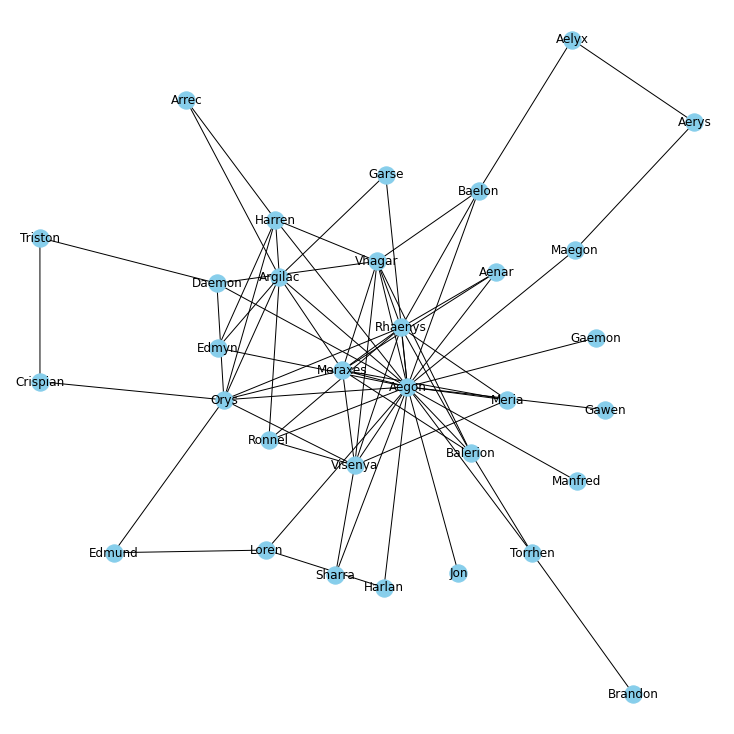

In [188]:
plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = 'skyblue', edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

In [218]:
net = Network(notebook = True, width = '800', height = '800', bgcolor = '#222222', font_color = 'white')

# setting up node size degree
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show('Fire_and_blood.html')

In [216]:
communities = community_louvain.best_partition(G)

In [220]:
nx.set_node_attributes(G, communities, 'group')
community_net = Network(notebook = True, width = '800px', height = '800px', bgcolor = '#222222', font_color = 'white')
community_net.from_nx(G)
community_net.show('Fire_and_blood.html')